In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import datetime as dt
from datetime import timedelta
import math

from sklearn.preprocessing import OrdinalEncoder


# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# Fuentes y estilos
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

font = {'family':'serif',
       'color':'darkred',
       'weight':'normal',
       'size':16,
       }


In [2]:
os.chdir('D:/DS/Kaggle')

In [3]:
# Load data
data = pd.read_csv('./pageviews.csv')
# content_category = pd.read_csv('./CONTENT_CATEGORY.csv')
# content_category_bottom = pd.read_csv('./CONTENT_CATEGORY_BOTTOM.csv')
# content_category_top = pd.read_csv('./CONTENT_CATEGORY_TOP.csv')
# device_data = pd.read_csv('./device_data.csv')
# page = pd.read_csv('./PAGE.csv')
# site_id = pd.read_csv('./SITE_ID.csv')
conversiones = pd.read_csv('./conversiones.csv', dtype={'mes' : 'object', 'anio' : 'object', 'USER_ID' : 'object'})

###  Procesamiento archivo conversiones

Elimino el '.0' de los datos de conversiones

In [4]:
conversiones['mes'] = pd.to_numeric(conversiones['mes'].str.replace('\.0', ''))
conversiones['anio'] = pd.to_numeric(conversiones['anio'].str.replace('\.0', ''))
conversiones['USER_ID'] = pd.to_numeric(conversiones['USER_ID'].str.replace('\.0', ''))
conversiones['Q'] = pd.to_numeric(conversiones['anio'].astype(str) + ((conversiones['mes']-1)//3 + 1).astype(str))
conversiones['Q-1'] = conversiones['Q'] - 1
conversiones['conversion'] = 1
conversiones.head()

,mes,anio,USER_ID,Q,Q-1,conversion
0,7,2018,1410,20183,20182,1
1,8,2018,10755,20183,20182,1
2,8,2018,8270,20183,20182,1
3,10,2018,7558,20184,20183,1
4,9,2018,10731,20183,20182,1


Probabilidad de conversión en un cuarto, basada en el cuarto anterior

In [5]:
print(conversiones.loc[conversiones['mes'] < 10,]['USER_ID'].nunique())
print(conversiones.loc[conversiones['mes'] >= 10,]['USER_ID'].nunique())
conversiones.head()

845
391


,mes,anio,USER_ID,Q,Q-1,conversion
0,7,2018,1410,20183,20182,1
1,8,2018,10755,20183,20182,1
2,8,2018,8270,20183,20182,1
3,10,2018,7558,20184,20183,1
4,9,2018,10731,20183,20182,1


In [6]:
convq = conversiones[['USER_ID','Q-1','conversion']].groupby(['USER_ID','Q-1']).sum()
convq.head()

,,conversion
USER_ID,Q-1,
13,20182,1
22,20183,1
40,20180,1
57,20181,1
92,20180,1


### Procesamiento archivo pageviews

Crear columnas anio y mes

In [7]:
data['USER_ID'] = pd.to_numeric(data['USER_ID'])

# Creo campos para hacer el join con el archivo conversiones
data['FEC_EVENT'] = pd.to_datetime(data['FEC_EVENT'])
data['anio'] = data['FEC_EVENT'].dt.year
data['mes'] = data['FEC_EVENT'].dt.month
data['Q'] = pd.to_numeric(data['anio'].astype(str) + ((data['mes']-1)//3 + 1).astype(str))
data.head()

,FEC_EVENT,PAGE,CONTENT_CATEGORY,CONTENT_CATEGORY_TOP,CONTENT_CATEGORY_BOTTOM,SITE_ID,ON_SITE_SEARCH_TERM,USER_ID,anio,mes,Q
0,2018-03-30 07:35:48,1,1,1,1,1,1,0,2018,3,20181
1,2018-03-30 07:35:52,2,2,2,2,2,1,0,2018,3,20181
2,2018-03-30 07:36:11,3,2,2,2,3,1,0,2018,3,20181
3,2018-03-30 07:36:16,4,2,2,2,3,1,0,2018,3,20181
4,2018-03-30 07:41:38,5,2,2,2,2,1,0,2018,3,20181


### Merge datasets pageviews y conversiones
Hago un left join para obtener las conversiones para el mismo cuarto y usuario y lleno con 0 en los casos que no hubo conversion

In [8]:
data = pd.merge(data, conversiones.loc[:,('Q','USER_ID','conversion')].drop_duplicates(), how='left')
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+0'})
print(data.shape)
data.head()

(17936934, 12)


,FEC_EVENT,PAGE,CONTENT_CATEGORY,CONTENT_CATEGORY_TOP,CONTENT_CATEGORY_BOTTOM,SITE_ID,ON_SITE_SEARCH_TERM,USER_ID,anio,mes,Q,conversion+0
0,2018-03-30 07:35:48,1,1,1,1,1,1,0,2018,3,20181,0.0
1,2018-03-30 07:35:52,2,2,2,2,2,1,0,2018,3,20181,0.0
2,2018-03-30 07:36:11,3,2,2,2,3,1,0,2018,3,20181,0.0
3,2018-03-30 07:36:16,4,2,2,2,3,1,0,2018,3,20181,0.0
4,2018-03-30 07:41:38,5,2,2,2,2,1,0,2018,3,20181,0.0


Hago un left join para obtener las conversiones para el cuarto SIGUIENTE y usuario y lleno con 0 en los casos que no hubo conversion

In [9]:
data = pd.merge(data, conversiones.loc[:,('Q-1','USER_ID','conversion')].drop_duplicates(), how='left', left_on=['USER_ID','Q'], right_on=['USER_ID','Q-1'])
data['conversion'] = data['conversion'].replace(np.nan, 0)
data = data.rename(columns = {'conversion':'conversion+1'})

data = data.drop(columns=['Q-1'])
print(data.shape)
data.head()

(17936934, 13)


,FEC_EVENT,PAGE,CONTENT_CATEGORY,CONTENT_CATEGORY_TOP,CONTENT_CATEGORY_BOTTOM,SITE_ID,ON_SITE_SEARCH_TERM,USER_ID,anio,mes,Q,conversion+0,conversion+1
0,2018-03-30 07:35:48,1,1,1,1,1,1,0,2018,3,20181,0.0,0.0
1,2018-03-30 07:35:52,2,2,2,2,2,1,0,2018,3,20181,0.0,0.0
2,2018-03-30 07:36:11,3,2,2,2,3,1,0,2018,3,20181,0.0,0.0
3,2018-03-30 07:36:16,4,2,2,2,3,1,0,2018,3,20181,0.0,0.0
4,2018-03-30 07:41:38,5,2,2,2,2,1,0,2018,3,20181,0.0,0.0


### Merge con el resto de los datasets para agregar las descripciones

In [13]:
# data = pd.merge(data, page, how='inner')
# data.head()

# data = pd.merge(data, content_category, how='inner')
# data = pd.merge(data, content_category_top, how='inner')
# data = pd.merge(data, content_category_bottom, how='inner')
# data = pd.merge(data, site_id, how='inner')
# print(data.head())

In [10]:
# Me quedo con los campos que voy a analizar
data = data.loc[:,['FEC_EVENT','USER_ID','Q','anio','mes','conversion+0','conversion+1'
                   #,'PAGE_descripcion'
                   ,'PAGE']]
data['diasemana'] = data['FEC_EVENT'].dt.dayofweek
data['diames'] = data['FEC_EVENT'].dt.day
data['hora'] = data['FEC_EVENT'].dt.hour

In [11]:
d = {
    1: 1,
    2: 2,
    3: 3,
    4: 1,
    5: 2,
    6: 3,
    7: 1,
    8: 2,
    9: 3,
    10: 1,
    11: 2,
    12: 3
}
data['month_of_quarter'] = data['mes'].map(d)

In [12]:
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3
1,2018-03-30 07:35:52,0,20181,2018,3,0.0,0.0,2,4,30,7,3
2,2018-03-30 07:36:11,0,20181,2018,3,0.0,0.0,3,4,30,7,3
3,2018-03-30 07:36:16,0,20181,2018,3,0.0,0.0,4,4,30,7,3
4,2018-03-30 07:41:38,0,20181,2018,3,0.0,0.0,5,4,30,7,3


#### Funcion para el calculo de probabilidades
- Calcula las probabilidades de conversion en los meses i+1, i+2, i+3 para una variable dada
- Asigna ordinales para cada valor
- Grafica los scatterplots

Devuelve un dataset con:
- probabilidades
- ordinales
- frecuencia 
- proporcion de cada categoria
- Cantidad de usuarios

In [13]:
def probabilidades(var, data, values=True):
#     for var in variables:
        print(var)
        probs = data.groupby(var).agg({'conversion+1':('sum')
                                , 'USER_ID':'nunique', var:'count'})
        probs = probs.rename(columns = {var:'freq', 'USER_ID':'user_count'})
        probs['proportion'] = probs['freq']/data.shape[0]

        for i in range(1,2):
        #   Calculo la probabilidad para cada categoria 
            probs['prob' + str(i)] = probs['conversion+' + str(i)]/probs['freq']

        #   Convierto cada valor al correspondiente ordinal
            enc = OrdinalEncoder()
            enc.fit(probs['prob' + str(i)].to_numpy().reshape(-1,1))
            probs['ord' + str(i)] = enc.transform(probs['prob' + str(i)].to_numpy().reshape(-1,1))

        #   Grafico los puntos en un scatterplot
            plt.figure(figsize=(16, 6))
            ax = sns.regplot(x='ord' + str(i), y='prob' + str(i), data=probs.reset_index(), fit_reg=False)
            if values:
                for line in range(0,probs.shape[0]):
                    ax.text(probs['ord' + str(i)].iloc[line]+0.1, probs['prob' + str(i)].iloc[line]
                            , probs.index[line]
                            , horizontalalignment='left', size='medium'
                            , color='black', weight='normal')

            plt.title('Probabilidad de conversion en el cuarto i + ' +str(i), fontdict=font)
            plt.xlabel(probs.index.name)
            plt.show()

        
        return probs


month_of_quarter


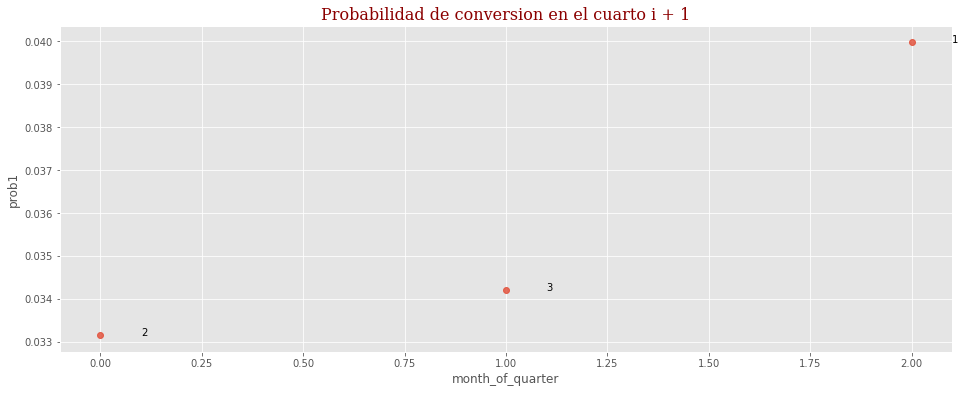

In [26]:
probs = probabilidades('month_of_quarter', data)
probs.to_csv('month_probs.csv', sep=',', header=True)

In [15]:
probs['month_q_prob'] = probs['prob1']
data = pd.merge(data, probs.reset_index()[['month_of_quarter','month_q_prob']], how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199
1,2018-03-30 07:35:52,0,20181,2018,3,0.0,0.0,2,4,30,7,3,0.034199
2,2018-03-30 07:36:11,0,20181,2018,3,0.0,0.0,3,4,30,7,3,0.034199
3,2018-03-30 07:36:16,0,20181,2018,3,0.0,0.0,4,4,30,7,3,0.034199
4,2018-03-30 07:41:38,0,20181,2018,3,0.0,0.0,5,4,30,7,3,0.034199


PAGE


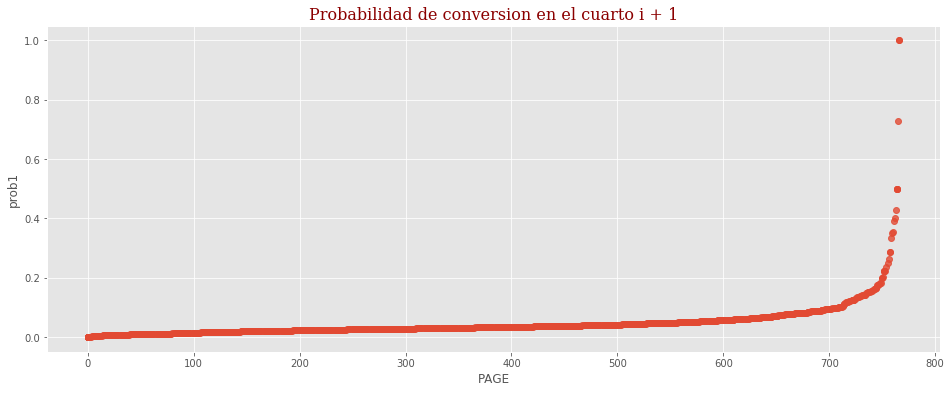

In [16]:
probs = probabilidades('PAGE', data, values=False)
# probs.sort_values(by='proportion', ascending=False)

probs.head()

probs.to_csv('page_probs.csv', sep=',', header=True)

In [17]:
page_group = pd.read_csv('./page_group.csv')
data = pd.merge(data, page_group, how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob,PAGE_descripcion,gm
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0
1,2018-03-04 18:04:12,0,20181,2018,3,0.0,0.0,1,6,4,18,3,0.034199,WEB : EMINENT,1.0
2,2018-03-09 06:28:16,0,20181,2018,3,0.0,0.0,1,4,9,6,3,0.034199,WEB : EMINENT,1.0
3,2018-03-29 10:46:02,0,20181,2018,3,0.0,0.0,1,3,29,10,3,0.034199,WEB : EMINENT,1.0
4,2018-03-16 06:58:29,0,20181,2018,3,0.0,0.0,1,4,16,6,3,0.034199,WEB : EMINENT,1.0


gm


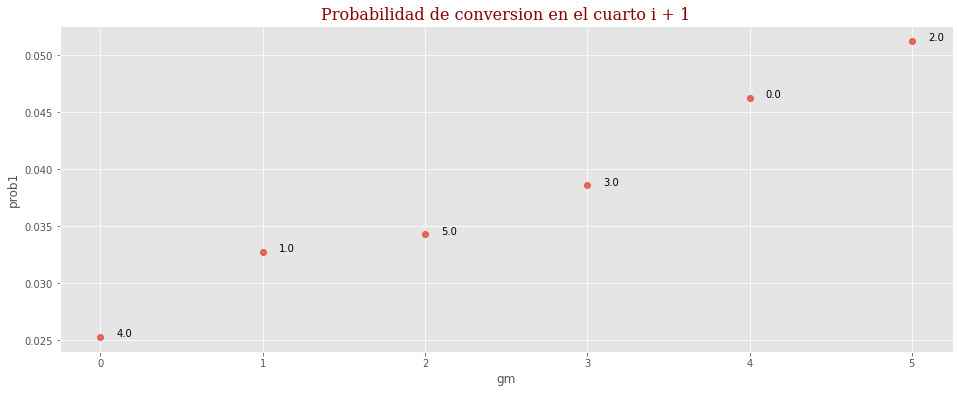

,conversion+1,user_count,freq,proportion,prob1,ord1
gm,,,,,,
0.0,317.0,1957,6848,0.000382,0.046291,4.0
1.0,252137.0,11639,7699417,0.429249,0.032748,1.0
2.0,79183.0,11606,1544651,0.086116,0.051263,5.0
3.0,94477.0,11541,2448899,0.136528,0.038579,3.0
4.0,11721.0,10804,463110,0.025819,0.025309,0.0


In [18]:
probs = probabilidades('gm', data)
probs.to_csv('gm_probs.csv', sep=',', header=True)
probs.head()

In [19]:
probs['gp_prob'] = probs['prob1']# + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['gm','gp_prob']], how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob,PAGE_descripcion,gm,gp_prob
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748
1,2018-03-04 18:04:12,0,20181,2018,3,0.0,0.0,1,6,4,18,3,0.034199,WEB : EMINENT,1.0,0.032748
2,2018-03-09 06:28:16,0,20181,2018,3,0.0,0.0,1,4,9,6,3,0.034199,WEB : EMINENT,1.0,0.032748
3,2018-03-29 10:46:02,0,20181,2018,3,0.0,0.0,1,3,29,10,3,0.034199,WEB : EMINENT,1.0,0.032748
4,2018-03-16 06:58:29,0,20181,2018,3,0.0,0.0,1,4,16,6,3,0.034199,WEB : EMINENT,1.0,0.032748


### Dia

diames


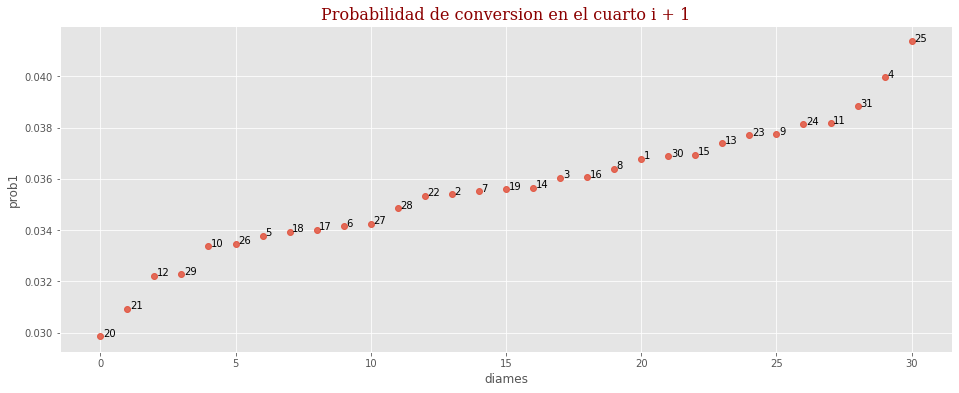

,conversion+1,user_count,freq,proportion,prob1,ord1
diames,,,,,,
1,22574.0,9891,613773,0.034218,0.036779,20.0
2,24421.0,10056,689884,0.038462,0.035399,13.0
3,29398.0,10324,815495,0.045465,0.036049,17.0
4,31814.0,10376,796030,0.044379,0.039966,29.0
5,34379.0,10709,1017940,0.056751,0.033773,6.0


In [20]:
probs = probabilidades('diames', data)
probs.to_csv('diames_probs.csv', sep=',', header=True)
probs.head()

In [21]:
probs['dm_prob'] = probs['prob1']# + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['diames','dm_prob']], how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob,PAGE_descripcion,gm,gp_prob,dm_prob
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875
1,2018-03-30 23:25:47,24,20181,2018,3,0.0,0.0,1,4,30,23,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875
2,2018-03-30 07:24:25,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875
3,2018-03-30 07:25:13,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875
4,2018-03-30 18:31:48,129,20181,2018,3,0.0,0.0,1,4,30,18,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875


diasemana


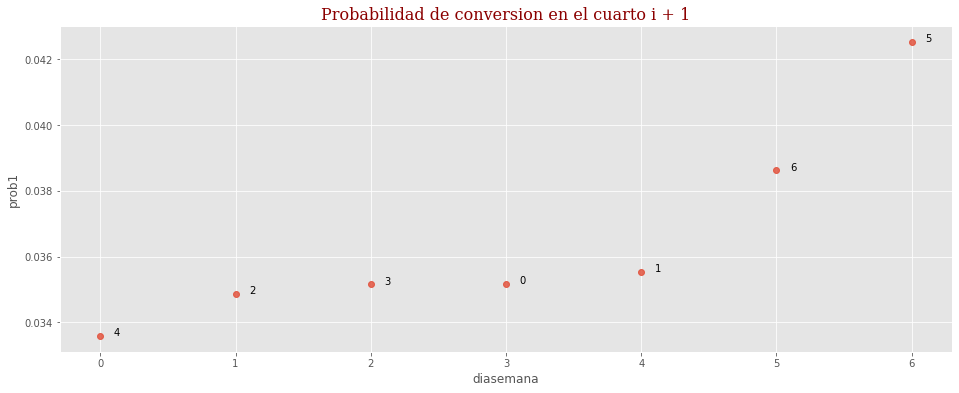

,conversion+1,user_count,freq,proportion,prob1,ord1
diasemana,,,,,,
0,125058.0,11424,3556010,0.198251,0.035168,3.0
1,111986.0,11380,3151448,0.175696,0.035535,4.0
2,116865.0,11432,3351480,0.186848,0.034870,1.0
3,114534.0,11432,3257922,0.181632,0.035156,2.0
4,96675.0,11374,2877953,0.160448,0.033592,0.0
5,38806.0,10134,912356,0.050865,0.042534,6.0
6,32047.0,9909,829765,0.046260,0.038622,5.0


In [22]:
probs = probabilidades('diasemana', data)
probs.to_csv('diasemana_probs.csv', sep=',', header=True)
probs

In [23]:
probs['ds_prob'] = probs['prob1']# + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['diasemana','ds_prob']], how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob,PAGE_descripcion,gm,gp_prob,dm_prob,ds_prob
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592
1,2018-03-30 23:25:47,24,20181,2018,3,0.0,0.0,1,4,30,23,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592
2,2018-03-30 07:24:25,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592
3,2018-03-30 07:25:13,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592
4,2018-03-30 18:31:48,129,20181,2018,3,0.0,0.0,1,4,30,18,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592


hora


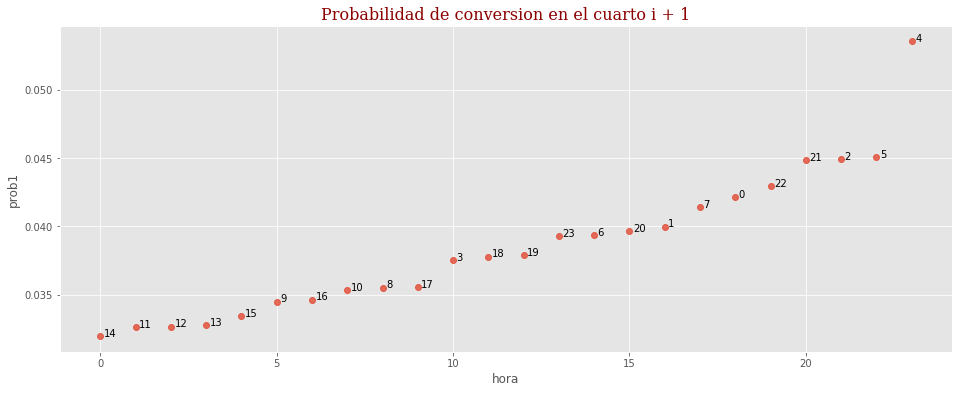

,conversion+1,user_count,freq,proportion,prob1,ord1
hora,,,,,,
0,8997.0,5974,213492,0.011902,0.042142,18.0
1,4119.0,3885,103024,0.005744,0.039981,16.0
2,2548.0,2509,56725,0.003162,0.044918,21.0
3,1776.0,1848,47351,0.002640,0.037507,10.0
4,2710.0,1690,50597,0.002821,0.053560,23.0
5,3378.0,2225,74944,0.004178,0.045074,22.0
6,7219.0,3951,183395,0.010224,0.039363,14.0
7,20394.0,6623,492523,0.027459,0.041407,17.0
8,40053.0,9336,1128173,0.062897,0.035503,8.0


In [24]:
probs = probabilidades('hora', data)
probs.to_csv('hora_probs.csv', sep=',', header=True)
probs

In [25]:
probs['h_prob'] = probs['prob1']# + probs['prob2'] + probs['prob3']
data = pd.merge(data, probs.reset_index()[['hora','h_prob']], how='inner')
data.head()

,FEC_EVENT,USER_ID,Q,anio,mes,conversion+0,conversion+1,PAGE,diasemana,diames,hora,month_of_quarter,month_q_prob,PAGE_descripcion,gm,gp_prob,dm_prob,ds_prob,h_prob
0,2018-03-30 07:35:48,0,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592,0.041407
1,2018-03-30 07:24:25,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592,0.041407
2,2018-03-30 07:25:13,24,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592,0.041407
3,2018-03-30 07:15:38,6571,20181,2018,3,0.0,0.0,1,4,30,7,3,0.034199,WEB : EMINENT,1.0,0.032748,0.036875,0.033592,0.041407
4,2018-11-30 07:47:46,341,20184,2018,11,0.0,0.0,1,4,30,7,2,0.033150,WEB : EMINENT,1.0,0.032748,0.036875,0.033592,0.041407


### Sesiones por usuario

In [ ]:
# Definimos un límite de tiempo entre eventos (Cuánto tiempo pasa hasta que expira la sesión?)
T = timedelta(seconds=30*60)

# data = data.loc[:,['USER_ID', 'FEC_EVENT', 'anio', 'mes']]
# Ordenamos el dataset por usuario y fecha de evento
data = data.sort_values(by=['USER_ID','FEC_EVENT'])

# Agregamos una columna con la fecha de evento anterior
data['last_date'] = data.groupby(['USER_ID'])['FEC_EVENT'].shift()

# Crear flag de nueva sesión cada vez que hay un nuevo ingreso
data['new_session'] = (((data['FEC_EVENT']
                            - data['last_date'])>=T) | (data['last_date'].isnull())).astype(int)
data['inc'] = data.groupby('USER_ID')['new_session'].cumsum()

# Creamos el id de sesión
data['session_id'] = data['USER_ID'].astype(str) + '_' + data['inc'].astype(str)
data = data.drop('inc', axis=1)

# print(data.head())

In [ ]:
data.head()

In [35]:
# data[['']]
data = data.drop(columns=['PAGE_descripcion', 'session_id'])
data.columns

Index(['FEC_EVENT', 'USER_ID', 'Q', 'anio', 'mes', 'conversion+0',
       'conversion+1', 'PAGE', 'diasemana', 'diames', 'hora',
       'month_of_quarter', 'month_q_prob', 'gm', 'gp_prob', 'dm_prob',
       'ds_prob', 'h_prob', 'last_date', 'new_session'],
      dtype='object')

In [36]:
data.to_csv('data.csv',sep=',',header=True)

# Agrupar por id de usuario, año y mes para el dataset final

Para cada usuario, año y mes, tengo la cantidad de sesiones, si convirtió o no en ese mes, y la fecha del último evento

In [34]:
grouped_data = data.groupby(['USER_ID','anio','mes','Q']
                            , as_index=False).agg({'PAGE':'count', 'conversion+0':'sum'
                                                   , 'FEC_EVENT':'max', 'gp_prob':'mean'
                                                   ,'dm_prob':'mean','ds_prob':'mean'
                                                   ,'h_prob':'mean', 'new_session':'sum', 'conversion+1':'sum'})
grouped_data['conversion+0'] = np.where(grouped_data['conversion+0']> 0, 1, 0)

In [35]:
grouped_data = grouped_data.groupby(['USER_ID','Q']
                            , as_index=False).agg({'PAGE':'count', 'conversion+0':'sum'
                                                   , 'FEC_EVENT':'max', 'gp_prob':'mean'
                                                   ,'dm_prob':'mean','ds_prob':'mean'
                                                   ,'h_prob':'mean', 'new_session':'sum', 'conversion+1':'sum'})


grouped_data['conversion+1'] = np.where(grouped_data['conversion+1']> 0, 1, 0)

grouped_data = grouped_data.rename(columns = {'PAGE':'paginas_visitadas', 'conversion+0':'conversiones_previas'
                                              ,'FEC_EVENT':'ultimo_evento','gp_prob':'page_group','dm_prob':'diames'
                                              ,'ds_prob':'diasemana', 'h_prob':'hora'
                                              ,'new_session':'cantidad_sesiones', 'conversion+1':'conversion'})


In [42]:
d = {20181: '2018-04-01',
     20182: '2018-07-01',
     20183: '2018-10-01',
     20184: '2019-01-01'
    }
grouped_data['next_quarter'] = grouped_data['Q'].map(d)

# Agregamos el tiempo desde la última transacción hasta el final del cuarto
grouped_data['tiempo_ultimo_evento'] = ((pd.to_datetime(grouped_data['next_quarter'])
                                        - grouped_data['ultimo_evento'])).astype('timedelta64[s]')
print(grouped_data.shape)
grouped_data.head()

(38269, 13)


,USER_ID,Q,paginas_visitadas,conversiones_previas,ultimo_evento,page_group,diames,diasemana,hora,cantidad_sesiones,conversion,next_quarter,tiempo_ultimo_evento
0,0,20181,3,0,2018-03-31 20:08:59,0.032008,0.035888,0.035298,0.035729,131,0,2018-04-01,13861.0
1,0,20182,3,0,2018-06-29 17:37:09,0.032840,0.035940,0.035691,0.035035,90,0,2018-07-01,109371.0
2,0,20183,3,0,2018-09-30 20:13:42,0.033387,0.035113,0.035653,0.035141,114,0,2018-10-01,13578.0
3,0,20184,3,0,2018-12-31 09:56:25,0.034517,0.035169,0.035735,0.035439,107,0,2019-01-01,50615.0
4,1,20181,3,0,2018-03-28 20:13:03,0.032513,0.035715,0.035298,0.035226,43,0,2018-04-01,272817.0


In [43]:
grouped_data.to_csv('observaciones_Vero.csv',sep=',',header=True)